# Test S3 for training

Let's run an end-to-end Keras training script with data from our S3 bucket. The data is stored on the S3 bucket in an HDF5 file. This test will give us an idea of the speed and cost of the training.

In [1]:
import keras
import numpy as np
import h5py
import os

/home/tony/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load HDF5 on the S3 bucket for training in Keras

This assumes you have [goofys](https://github.com/kahing/goofys) setup on your local machine.
You'll probably first need to download and install the [AWS CLI](https://aws.amazon.com/cli/). If AWS CLI is properly installed then you should be able to run this command from your local Linux machine:

` aws s3 ls s3://dse-cohort3-group5`

If that works, then you can create a local directory with the command:

`mkdir -p s3bucket`

If that works, then you can use goofys to link the local directory with the s3 bucket.

`./goofys dse-cohort3-group5 s3bucket`

Once that is done, then you can access the s3bucket as if it were a local folder on your Linux machine.


In [2]:
root_dir = !pwd
s3bucket_path = root_dir[0] + '/../s3bucket_goofys/' # remote S3 via goofys
#s3bucket_path = '/Users/aluthra/Documents/DSE/ucsd-dse-capstone/' # Local storage (for sanity test)
path_to_hdf5 = s3bucket_path + 'LUNA16/hdf5-files/64x64x64-patch.hdf5'
path_to_hdf5 = s3bucket_path + 'mnist/mnist_lshape_28x28x28.hdf5'
hdf5_file = h5py.File(path_to_hdf5, 'r') # open in read-only mode

In [3]:
print("Valid hdf5 file in 'read' mode: " + str(hdf5_file))
file_size = os.path.getsize(path_to_hdf5)
print('Size of hdf5 file: {:.3f} GB'.format(file_size/2.0**30))

Valid hdf5 file in 'read' mode: <HDF5 file "mnist_lshape_28x28x28.hdf5" (mode r)>
Size of hdf5 file: 0.186 GB


In [4]:
print("There are {} images in the dataset.".format(hdf5_file['input'].shape[0]))

There are 1137 images in the dataset.


In [5]:
print("The datasets within the HDF5 file are:\n {}".format(list(hdf5_file.values())))

The datasets within the HDF5 file are:
 [<HDF5 dataset "input": shape (1137, 21952), type "<f8">, <HDF5 dataset "output": shape (1137,), type "<i8">]


In [6]:
def get_class_idx(hdf5_file, classid = 0):
    '''
    Get the indices for the class classid
    '''
    # 1. Select indices from class 0 and 1
    #idx = np.where(hdf5_file["output"][:,0] == classid)[0]  # Indices for class classid
    idx = np.where(hdf5_file['output'][:] == classid)[0]
    return idx


In [7]:
def remove_exclude_subset_idx(hdf5_file, idx, excluded_subset=0):
    '''
    Remove indices for the subset excluded_subset
    '''   

    subsets = hdf5_file["subsets"][:,0]
    excluded_idx = np.where(subsets == excluded_subset)[0] # indices
    
    return np.setdiff1d(idx, excluded_idx)  # Remove the indices of the excluded subset
    

In [8]:
def get_idx_for_classes(hdf5_file, excluded_subset=0):
    '''
    Get the indices for each class but don't include indices from excluded subset
    '''
    
    idx = {}
#     idx[0] = get_class_idx(hdf5_file, 0)
#     idx[1] = get_class_idx(hdf5_file, 1)
    idx[0] = get_class_idx(hdf5_file, 4)
    idx[1] = get_class_idx(hdf5_file, 5)
    
#     idx[0] = remove_exclude_subset_idx(hdf5_file, idx[0], excluded_subset)
#     idx[1] = remove_exclude_subset_idx(hdf5_file, idx[1], excluded_subset)
    
    return idx

## Custom HDF5 dataloader

This is the first pass at our custom HDF5 data loader.
We'll need to add data augmentation and class balancing to this.

In [9]:
def get_random_idx(hdf5_file, idx, batch_size = 4):
    '''
    Batch size needs to be even.
    This is yield a balanced set of random indices for each class. 
    '''
        
    idx0 = idx[0]
    idx1 = idx[1]
    
    # 2. Shuffle the two indices
    np.random.shuffle(idx0)  # This shuffles in place
    np.random.shuffle(idx1)  # This shuffles in place

    # 3. Take half of the batch from each class
    idx0_shuffle = idx0[0:(batch_size//2)]
    idx1_shuffle = idx1[0:(batch_size//2)]

    # Need to sort final list in order to slice
    return np.sort(np.append(idx0_shuffle, idx1_shuffle))


In [10]:
def img_rotate(img):
    '''
    Perform a random rotation on the tensor
    `img` is the tensor
    '''
    shape = img.shape
    # This will flip along n-1 axes. (If we flipped all n axes then we'd get the same result every time)
    ax = np.random.choice(len(shape)-1,2, replace=False) # Choose randomly which axes to flip
    return np.flip(img.swapaxes(ax[0], ax[1]), ax[0]) # Random +90 or -90 rotation

In [11]:
def img_flip(img):
    '''
    Performs a random flip on the tensor.
    If the tensor is C x H x W x D this will perform flips on two of the C, H, D dimensions
    If the tensor is C x H x W this will perform flip on either the H or the W dimension.
    `img` is the tensor
    '''
    shape = img.shape
    # This will flip along n-1 axes. (If we flipped all n axes then we'd get the same result every time)
    ax = np.random.choice(len(shape)-1,len(shape)-2, replace=False) + 1 # Choose randomly which axes to flip
    for i in ax:
        img = np.flip(img, i) # Randomly flip along all but one axis
    return img

In [12]:
def augment_data(imgs):
    ''' 
    Performs random flips, rotations, and other operations on the image tensors.
    '''
    
    imgs_length = imgs.shape[0]
    
    for idx in range(imgs_length):
        img = imgs[idx, :]
        
        if (np.random.rand() > 0.5):
            
            if (np.random.rand() > 0.5):
                img = img_rotate(img)

            if (np.random.rand() > 0.5):
                img = img_flip(img)
        
        else:
            
            if (np.random.rand() > 0.5):
                img = img_flip(img)
                
            if (np.random.rand() > 0.5):
                img = img_rotate(img)

        imgs[idx,:] = img
        
    return imgs

In [13]:
def generate_data(hdf5_file, batch_size=50, exclude_subset=5):
    """Replaces Keras' native ImageDataGenerator."""
    """ Randomly select batch_size rows from the hdf5 file dataset """
    
    input_shape = tuple([batch_size] + list(hdf5_file['input'].attrs['lshape']) + [1])
    idx_master = get_idx_for_classes(hdf5_file, exclude_subset) 
    
    while True:
        
        random_idx = get_random_idx(hdf5_file, idx_master, batch_size)
        imgs = hdf5_file["input"][random_idx,:]
        imgs = imgs.reshape(input_shape)
        ## Need to augment 
        imgs = augment_data(imgs)
        
        #classes = hdf5_file["output"][random_idx,0]
        classes = hdf5_file["output"][list(random_idx)] - 4  # Change me back Anil
        
        yield imgs, classes

In [14]:
input_shape = tuple(list(hdf5_file["input"].attrs["lshape"]) + [1])  # Get the original shape of the tensor
batch_size = 10   # Batch size to use

In [79]:
#imgs, classes = generate_data(hdf5_file, batch_size=batch_size, exclude_subset=2)

(10, 28, 28, 28, 1)
(10,)
(10, 28, 28, 28, 1)
(10,)
(10, 28, 28, 28, 1)
(10,)


ValueError: too many values to unpack (expected 2)

In [116]:
imgs = hdf5_file["inputs"][random_idx,:]

In [120]:
imgs = imgs.reshape(10,64,64,64, 1)

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

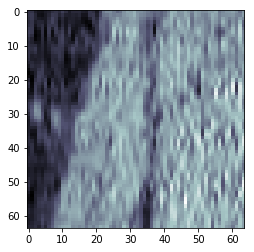

In [126]:
plt.imshow(imgs[9,:,:,32,0], cmap='bone')

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D
from keras import backend as K

In [4]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3,3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv3D(64, (3, 3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
tb_log = keras.callbacks.TensorBoard(log_dir='./tb_logs', histogram_freq=0, batch_size=batch_size, 
                            write_graph=True, 
                            write_grads=True, write_images=True, 
                            embeddings_freq=0, embeddings_layer_names=None, 
                            embeddings_metadata=None)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 26, 26, 26, 32)    896       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 24, 24, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 12, 12, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 12, 64)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 110592)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               14155904  
_________________________________________________________________
dro

## Train with fit_generator


In [22]:
history = model.fit_generator(generate_data(hdf5_file, batch_size, exclude_subset=2),
                    steps_per_epoch=10, epochs=3, callbacks=[tb_log])

Epoch 1/3
10/10 [==============================] - 112s 11s/step - loss: 0.3703 - acc: 0.8600
Epoch 2/3
10/10 [==============================] - 75s 7s/step - loss: 0.2993 - acc: 0.8900
Epoch 3/3
10/10 [==============================] - 72s 7s/step - loss: 0.3149 - acc: 0.9100


In [7]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
